In [ ]:
import types
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import GetSymmSSSR as SSSR
import networkx as nx

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [ ]:
with open("./smiles.txt") as f:
    smiles = [line.strip("\n") for line in f.readlines()]
    
smis = smiles[:100]
smi = smiles[2]

In [ ]:
def vis_smi(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    return mol_with_atom_index(mol)

In [ ]:
smi = "CC([NH3+])C1=C([O-])C=CO1"  # O=C([O])C1=CC[NH2]C1
mol = Chem.MolFromSmiles(smi)
Chem.AddHs(mol)

In [ ]:
smi = "CC=C1C(=O)C=CO1.N"
mol = Chem.MolFromSmiles(smi)
Chem.AddHs(mol)

In [ ]:
vis_smi(smi=smi)

In [ ]:
_ = 2
smi = smiles[_]
mol = Chem.MolFromSmiles(smi)
mol_with_atom_index(mol)

In [ ]:
sssr = SSSR(mol)

In [ ]:
_fp = Chem.GetMorganFingerprint #Chem.RDKFingerprint
_smis = [Chem.MolFragmentToSmiles(mol, x, kekuleSmiles=True) for x in sssr]
_smiss = ["C1=CC=CC=C1", "C1CNCCN1", "C1CCSN1", "C1=CC=CC=C1"]
_mols = [Chem.MolFromSmiles(x) for x in _smis]
_molshs = [Chem.AddHs(Chem.MolFromSmiles(x)) for x in _smis]
_molss = [Chem.MolFromSmiles(x) for x in _smiss]
_molsshs = [Chem.AddHs(Chem.MolFromSmiles(x)) for x in _smiss]
_fps = [_fp(x, 2) for x in _mols]
_fpshs = [_fp(x, 2) for x in _molshs]
_fpss = [_fp(x, 2) for x in _molss]
_fpsshs = [_fp(x, 2) for x in _molsshs]

In [ ]:
testsmi = Chem.MolFragmentToSmiles(mol, [17, 23], kekuleSmiles=True)
testmol = Chem.MolFromSmiles(testsmi)
testmol
Chem.GetMorganFingerprint(testmol, 2)

In [ ]:
Draw.MolsToGridImage(_mols+_molshs+_molss+_molsshs, molsPerRow=4)

In [ ]:
from rdkit import DataStructs

_a, _b = _fpss, _fpsshs
for n in range(4):
    print(n, DataStructs.DiceSimilarity(_a[n], _b[n]), _a[n] == _b[n])

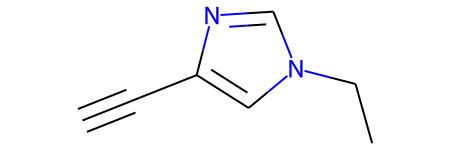

In [1]:
from ChemGraph import *
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
smi = "CCN1C=NC(=C1)C#C"
mol = Chem.MolFromSmiles(smi)
atoms = [2, 3, 4, 5, 6]

mol

In [8]:
atom = mol.GetAtomWithIdx(2)
help(atom)

Help on Atom in module rdkit.Chem.rdchem object:

class Atom(Boost.Python.instance)
 |  The class to store Atoms.
 |  Note that, though it is possible to create one, having an Atom on its own
 |  (i.e not associated with a molecule) is not particularly useful.
 |  
 |  Method resolution order:
 |      Atom
 |      Boost.Python.instance
 |      builtins.object
 |  
 |  Static methods defined here:
 |  
 |  ClearProp(...)
 |      ClearProp( (Atom)arg1, (str)arg2) -> None :
 |          Removes a particular property from an Atom (does nothing if not already set).
 |          
 |            ARGUMENTS:
 |              - key: the name of the property to be removed.
 |          
 |      
 |          C++ signature :
 |              void ClearProp(RDKit::Atom const*,char const*)
 |  
 |  DescribeQuery(...)
 |      DescribeQuery( (Atom)arg1) -> str :
 |          returns a text description of the query. Primarily intended for debugging purposes.
 |          
 |          
 |      
 |          C++ s

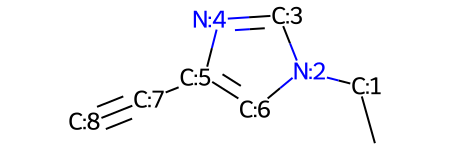

In [2]:
mol_with_atom_index(mol)

In [3]:
get_substruc(mol, atoms)

ArgumentError: Python argument types in
    RWMol.AddBond(RWMol, Atom, Atom, BondType)
did not match C++ signature:
    AddBond(RDKit::ReadWriteMol {lvalue}, unsigned int beginAtomIdx, unsigned int endAtomIdx, RDKit::Bond::BondType order=rdkit.Chem.rdchem.BondType.UNSPECIFIED)

In [ ]:
class Node(object):
    """
    Node object in the substructure graph.
    """
    def __init__(self, smiles, idx, nbrs=[], FingerprintFunc=None, includeHs=True):
        self.smi = smiles
        self.mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if includeHs:
            self.mol = Chem.AddHs(self.mol)
        if FingerprintFunc:
            self.fp = FingerprintFunc(self.mol)
        
        self.idx = idx
        self.nbrs = nbrs
    
    def __str__(self):
        return self.smi
    
    def update_fp(self, FingerprintFunc):
        self.fp = FingerprintFunc(self.mol)
    
    def add_neighbor(self, nbr):
        try:
            self.nbrs.extend(nbr)
        except:
            self.nbrs.extend([nbr])

In [ ]:
import types
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import GetSymmSSSR as SSSR
import networkx as nx


PTABLE = Chem.GetPeriodicTable()





class SubstructGraph(object):
    """
    Substructure graph of a molecule. Hydrogen atoms are ignored when building the graph but may be considered in features.
    """
    def __init__(self, xyz_file, Hs_in_fragments=True, Hs_in_linkages=False):
        self.filepath = xyz_file
        self.filaname = xyz_file.split("/")[-1]
        self.parse_xyz_file()  # self.n_atoms, self.smi, self.atoms, self.coord, self.gap
        self.mol = Chem.MolFromSmiles(self.smi)
        self.mol_Hs = Chem.AddHs(self.mol)

        self.fragments = []
        self.Hs_in_fragments = Hs_in_fragments
        self.linkages = []
        self.Hs_in_linkages = Hs_in_linkages
        self.graph = self.init_graph(Hs_in_fragments, Hs_in_linkages)   # nx graph object
    
    def parse_xyz_file(self):
        self.atoms, self.atomic_nums, self.coords = [], [], []
        with open(self.filepath, "r") as f:
            self.n_atoms = int(f.readline())
            self.gap = float(f.readline().split()[-1])
            for _ in range(self.n_atoms):
                line = f.readline().split()
                self.atoms.append(line[0])
                self.atomic_nums.append(PTABLE.GetAtomicNumber(line[0]))
                self.coords.append([float(x.replace('.*^', 'e').replace('*^', 'e')) for x in line[1:]])
            f.readline()    # frequencies
            self.smi = f.readline().split()[0]

    def init_graph(self, Hs_in_fragments=True, Hs_in_linkages=False):
        """
        Decompose the atomic graph of a molecule into a substructure graph. Hydrogen atoms are ignored.
        -------------------------------------------------------------------------------------------
        Returns:
            nx.Graph() object
        """
        graph = nx.Graph()  # initiate graph
        graph.graph["FilePath"] = self.filepath
        graph.graph['Smiles'] = self.smi
        graph.graph['Gap'] = self.gap

        if self.n_atoms < 3:
            _nodes = [list(range(self.n_atoms))]
        else:
            _nodes = [list(x) for x in SSSR(self.mol)]    # Get smallest set of smallest rings (SSSR)
                                                # Note that the definition is not unique
            for bond in self.mol.GetBonds():
                if not bond.IsInRing():     # include the rest of the bonds that are not in a ring
                    _nodes.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        
        graph.add_nodes_from([(i, {'AtomIdxs': atoms}) for i, atoms in enumerate(_nodes)])
        
        for i in graph.nodes:
            try:  
                _smi = Chem.MolFragmentToSmiles(self.mol, graph.nodes[i]['AtomIdxs'], kekuleSmiles=True)
            except:
                _smi = Chem.MolFragmentToSmiles(self.mol, graph.nodes[i]['AtomIdxs'], kekuleSmiles=False)
                # print(f"Node failed\t{_smi}\t{self.filaname}")
            _mol = Chem.MolFromSmiles(_smi, sanitize=True)
            if Hs_in_fragments:
                try:
                    _mol = Chem.AddHs(_mol)
                except:
                    print(_smi)
            
            self.fragments.append(_smi)
            graph.nodes[i]['Smiles'] = _smi
            graph.nodes[i]['Molecule'] = _mol
            graph.nodes[i]['Atoms'] = [self.atomic_nums[x] for x in graph.nodes[i]['AtomIdxs']]
            graph.nodes[i]['Coordinates'] = [self.coords[x] for x in graph.nodes[i]['AtomIdxs']]
        
        self.n_fragments = len(self.fragments)
        _edges = {}
        for i in range(self.n_fragments)[:-1]:
            a = list(graph.nodes)[i]
            for j in range(self.n_fragments)[i+1:]:
                b = list(graph.nodes)[j]
                shared_atoms = list(set(graph.nodes[a]['AtomIdxs']) & set(graph.nodes[b]['AtomIdxs']))
                if shared_atoms:
                    graph.add_edge(a, b, LinkAtomIdxs=shared_atoms)
                    try:
                        _smi = Chem.MolFragmentToSmiles(self.mol, shared_atoms, kekuleSmiles=True)
                    except:
                        _smi = Chem.MolFragmentToSmiles(self.mol, shared_atoms, kekuleSmiles=False)
                        print(f"Edge failed\t{_smi}\t{self.filaname}")
                    _mol = Chem.MolFromSmiles(_smi, sanitize=True)
                    if Hs_in_linkages:
                        try:
                            _mol = Chem.AddHs(_mol)
                        except:
                            pass
                            # print(_smi)

                    self.linkages.append(_smi)
                    graph.edges[a, b]['Smiles'] = _smi
                    graph.edges[a, b]['Molecule'] = _mol
        return graph
    
    def update_graph(self, NodeConverter=None, EdgeConverter=None):
        """Extract features from nodes and/or edges or update previous features.

        Args:
            NodeConverter (Function, optional): Node feature extraction function. Defaults to None.
            EdgeConverter (Function, optional): Edge feature extraction function. Defaults to None.
        """
        if isinstance(NodeConverter, types.FunctionType):
            for i in list(self.graph.nodes):
                self.graph[i]['Features'] = NodeConverter(self.graph[i]['Molecule'])
        elif NodeConverter is not None:
            raise Exception("NodeConverter is not a valid converting function.")

        if isinstance(EdgeConverter, types.FunctionType):
            for (a, b, mol) in self.graph.edges.data('Molecule'):
                self.graph.edges[a, b]['Features'] = EdgeConverter(mol)
        elif EdgeConverter is not None:
            raise Exception("EdgeConverter is not a valid converting function.")

In [ ]:
import os
print(os.getcwd())

file_path = "./baselines/data/qm9/xyz/dsgdb9nsd_000608.xyz"
filenames = [filename for filename in os.listdir("./baselines/data/qm9/xyz/") if filename.endswith(".xyz")]
for file_path in filenames:
    G = SubstructGraph("./baselines/data/qm9/xyz/"+file_path)

In [ ]:
Chem.MolFragmentToCXSmiles

In [ ]:
class GraphLegion(object):
    """_summary_

    Args:
        object (_type_): _description_
    """

In [ ]:
def tree_decomp(smiles):
    """
    Decompose the atomic graph of a molecule into a substructure graph. Hydrogen atoms are ignored.
    -------------------------------------------------------------------------------------------
    Args:
        smi (str): SMILES string of a molecule (str)
    Returns:
        decomposed substructures (list) & edges (list)
    """
    smi = smiles
    mol = Chem.MolFromSmiles(smi)  # molecule with implicit Hs
    
    n_atoms = mol.GetNumAtoms()
    if n_atoms <= 2:
        return [list(range(n_atoms))], []  # one node, no edge
    
    nodes = [list(x) for x in SSSR(mol)]  # Get smallest set of smallest rings (SSSR)
                                                                # Note that the definition is not unique
    for bond in mol.GetBonds():
        if not bond.IsInRing():  # get the bonds that are not in a ring
            nodes.apend([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    
    edges = []
    